In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))
options(future.globals.maxSize= 891289600 * 160)
# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [ ]:

classFiltSeurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil_sample3.rds')

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil300_sample3_SCT.rds'))



In [2]:

seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_1031_Amygdala/amygdala_snrna_all_soupX_fil300_sample3_SCT.rds')


In [3]:
seurat
sum(table(seurat$group))
table(seurat$group)

An object of class Seurat 
45012 features across 75816 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

[1] 75816


MQ179-76T61  MQ277L-371  MQ277L-459  MQ277L-460  MQ277L-461  MQ277L-462 
       4013       17644        6194        9808        4340       14143 
 MQ277L-463 MQC286R-229 
       8572       11102 

In [4]:
seurat$sample='test'
all_n=unique(seurat$group)
name1=all_n[grep('MQC286R',all_n)]
name2=all_n[grep('MQ277L',all_n)]
name3=all_n[grep('MQ179',all_n)]
name1
name2
name3
seurat@meta.data[seurat@meta.data$group %in% name1,]$sample='MQC286'
seurat@meta.data[seurat@meta.data$group %in% name2,]$sample='MQ277'
seurat@meta.data[seurat@meta.data$group %in% name3,]$sample='MQ179'
sum(table(seurat$sample))
table(seurat$sample)


[1] "MQC286R-229"

[1] "MQ277L-459" "MQ277L-460" "MQ277L-461" "MQ277L-462" "MQ277L-463"
[6] "MQ277L-371"

[1] "MQ179-76T61"

[1] 75816


 MQ179  MQ277 MQC286 
  4013  60701  11102 

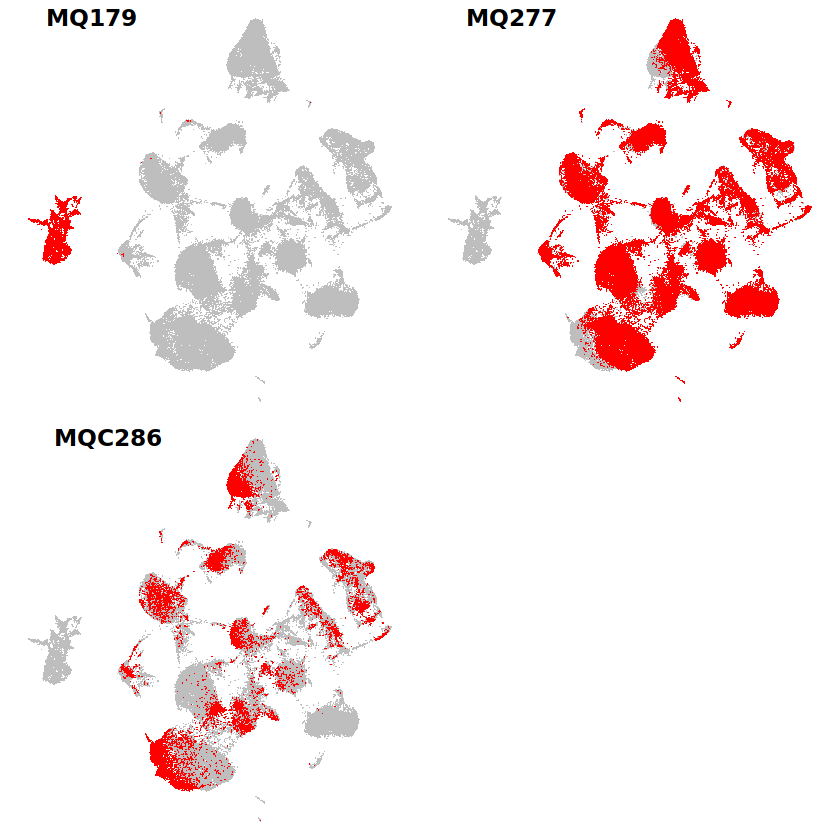

In [5]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(seurat, highlightBy="sample", showAllPoints=T, size=0.1)

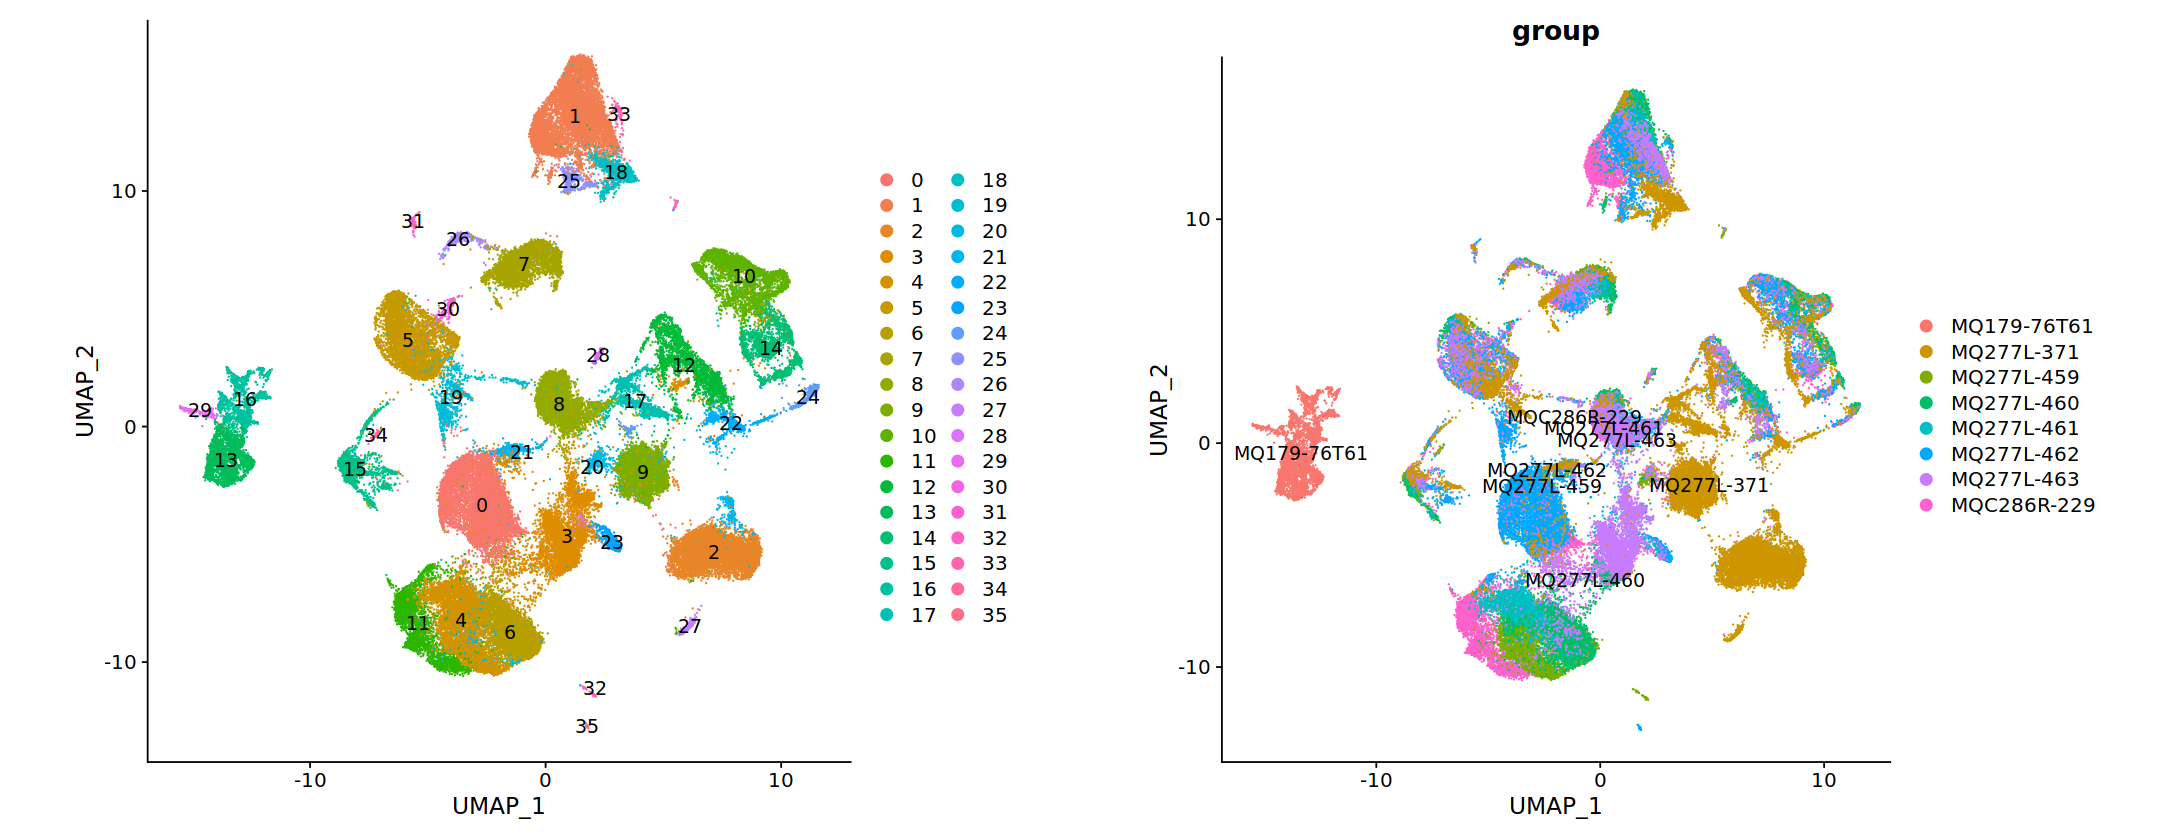

In [6]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="group", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

In [7]:
classFiltSeurat=seurat
# Run harmony
DefaultAssay(classFiltSeurat) = "SCT"
options(repr.plot.width=6, repr.plot.height=2.5)
classFiltSeurat = RunHarmony(
classFiltSeurat, group.by.vars="sample", plot_convergence=T,
assay.use="SCT", reduction = "pca", dims.use=1:50
)
classFiltSeurat = classFiltSeurat %>%
FindNeighbors(reduction="harmony", dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(reduction="harmony", dims = 1:50)
return(classFiltSeurat)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 3790800)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:46:09 UMAP embedding parameters a = 0.9922 b = 1.112

16:46:09 Read 75816 rows and found 50 numeric columns

16:46:09 Using Annoy for neighbor search, n_neighbors = 30

16:46:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[--

An object of class Seurat 
45012 features across 75816 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

In [8]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(classFiltSeurat, highlightBy="sample", showAllPoints=T, size=0.1)
        

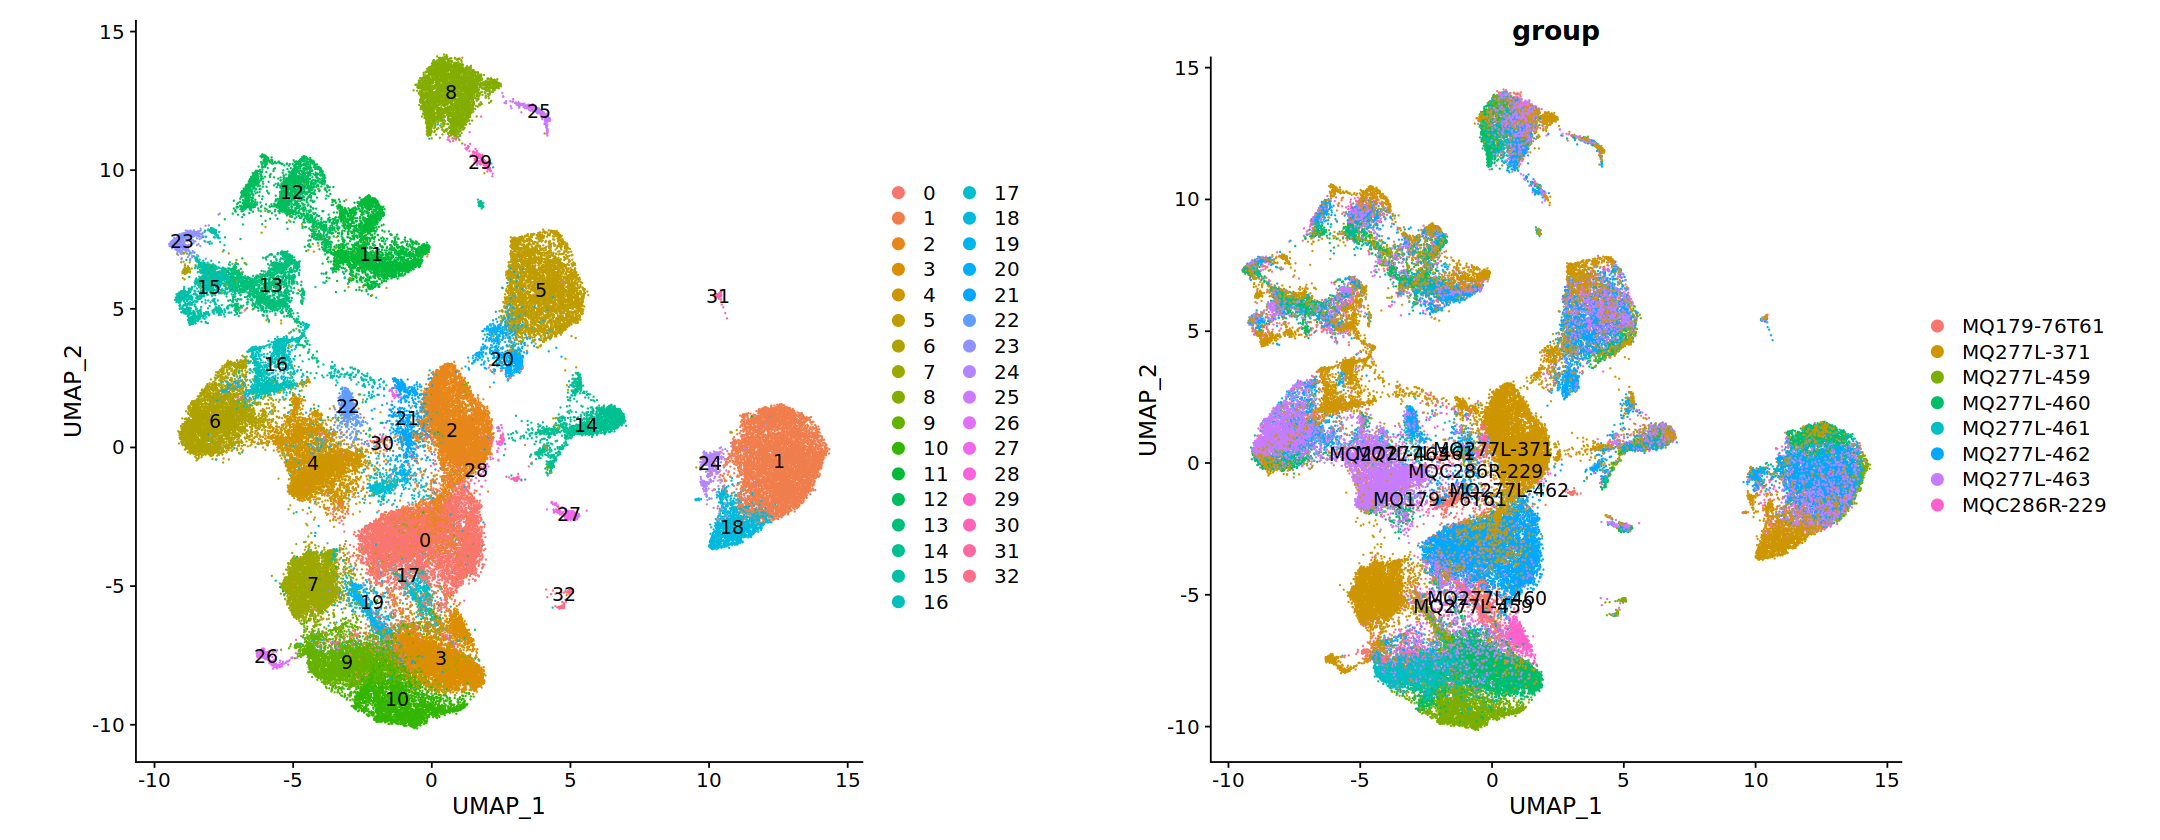

In [9]:
seurat=classFiltSeurat
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="group", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: DLX6-AS1, GJA1, ZMYDN10, ALPHA-SMA, PDGFRALPHA, VECAD, CD105, COX4l2, MOTCH3, CS3CR1”


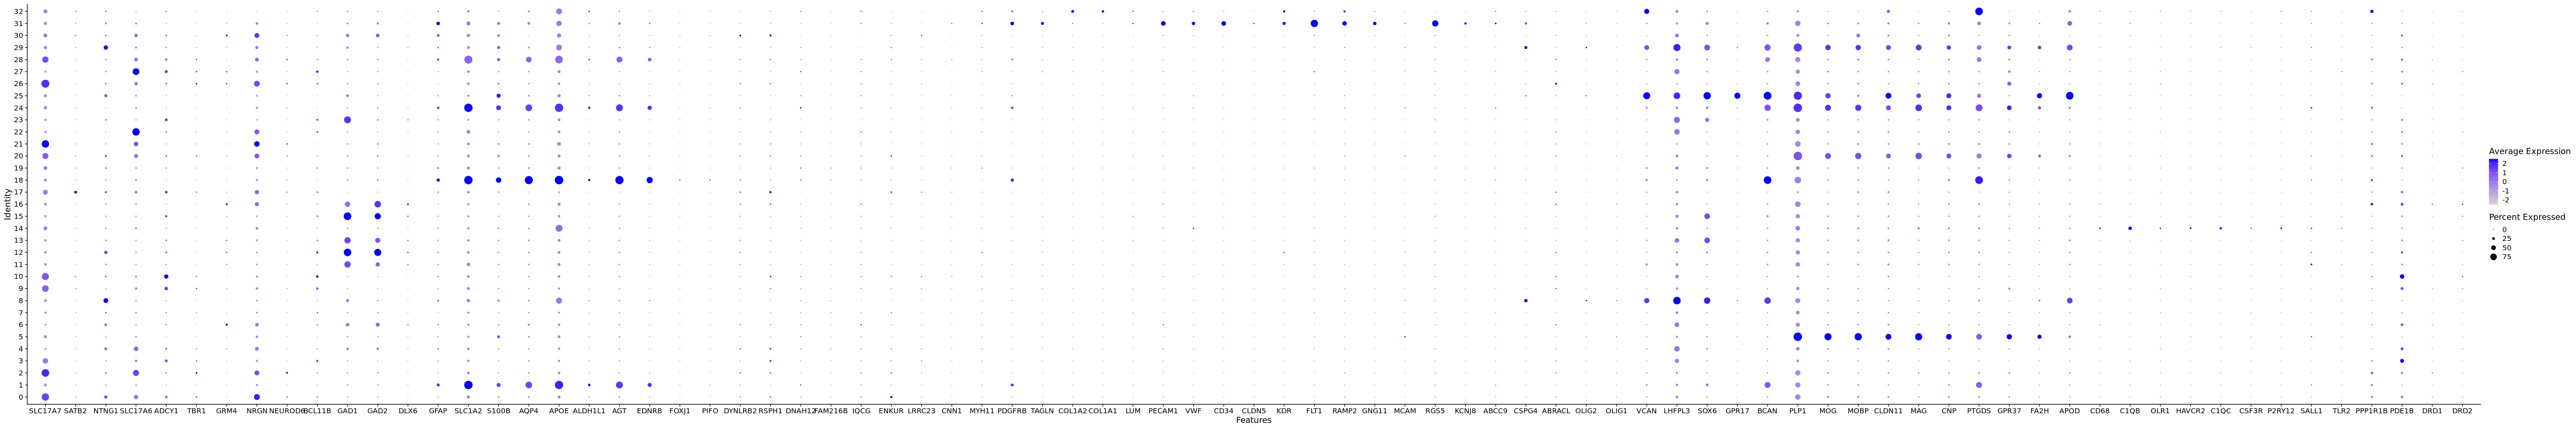

In [10]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2',# Microglia
    'PPP1R1B','BCL11B','PDE1B','DRD1','DRD2'
)



selectMarkers=selectMarkers

selectMarkers=selectMarkers[!duplicated(selectMarkers)]
Idents(seurat) = "seurat_clusters"
options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)




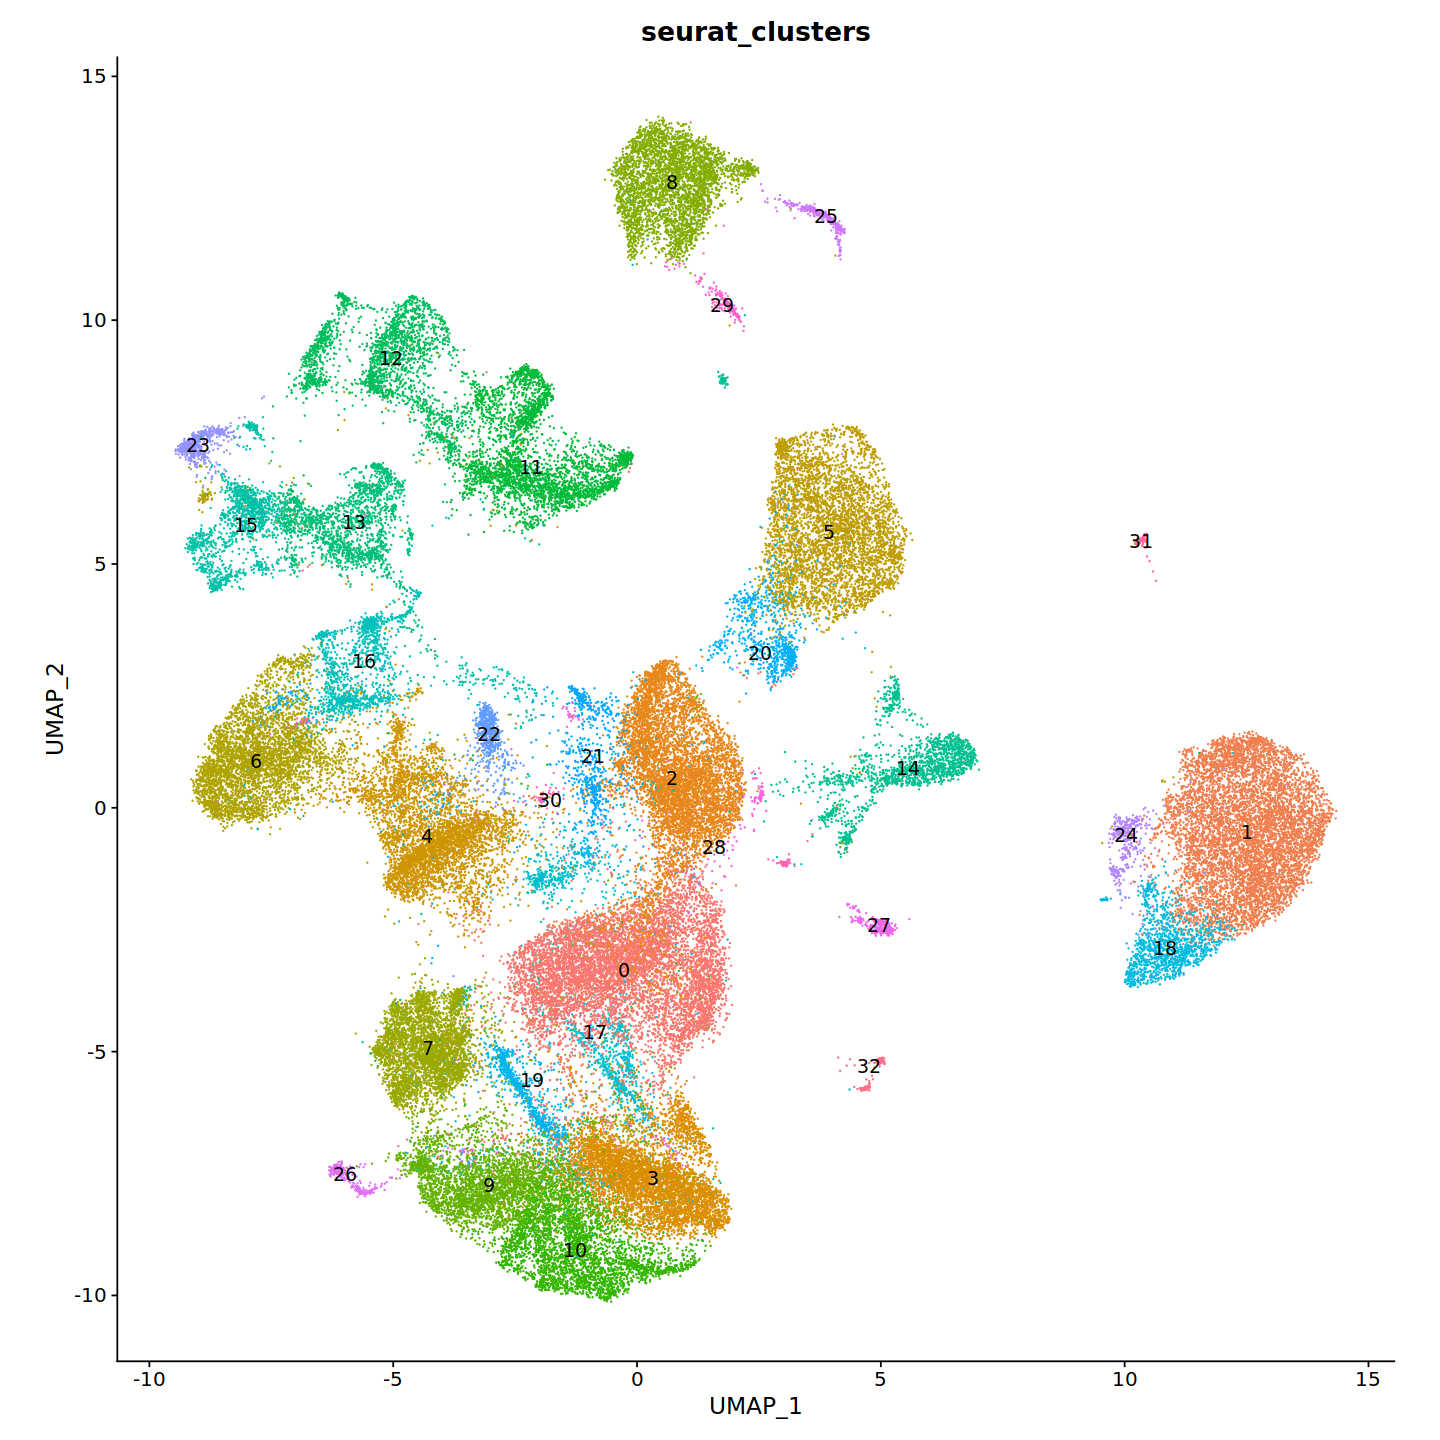

In [14]:
options(repr.plot.width=12, repr.plot.height=12)
DimPlot(seurat,group.by = 'seurat_clusters',label=T,raster=FALSE)+coord_fixed()+NoLegend()



Joining, by = "cell"


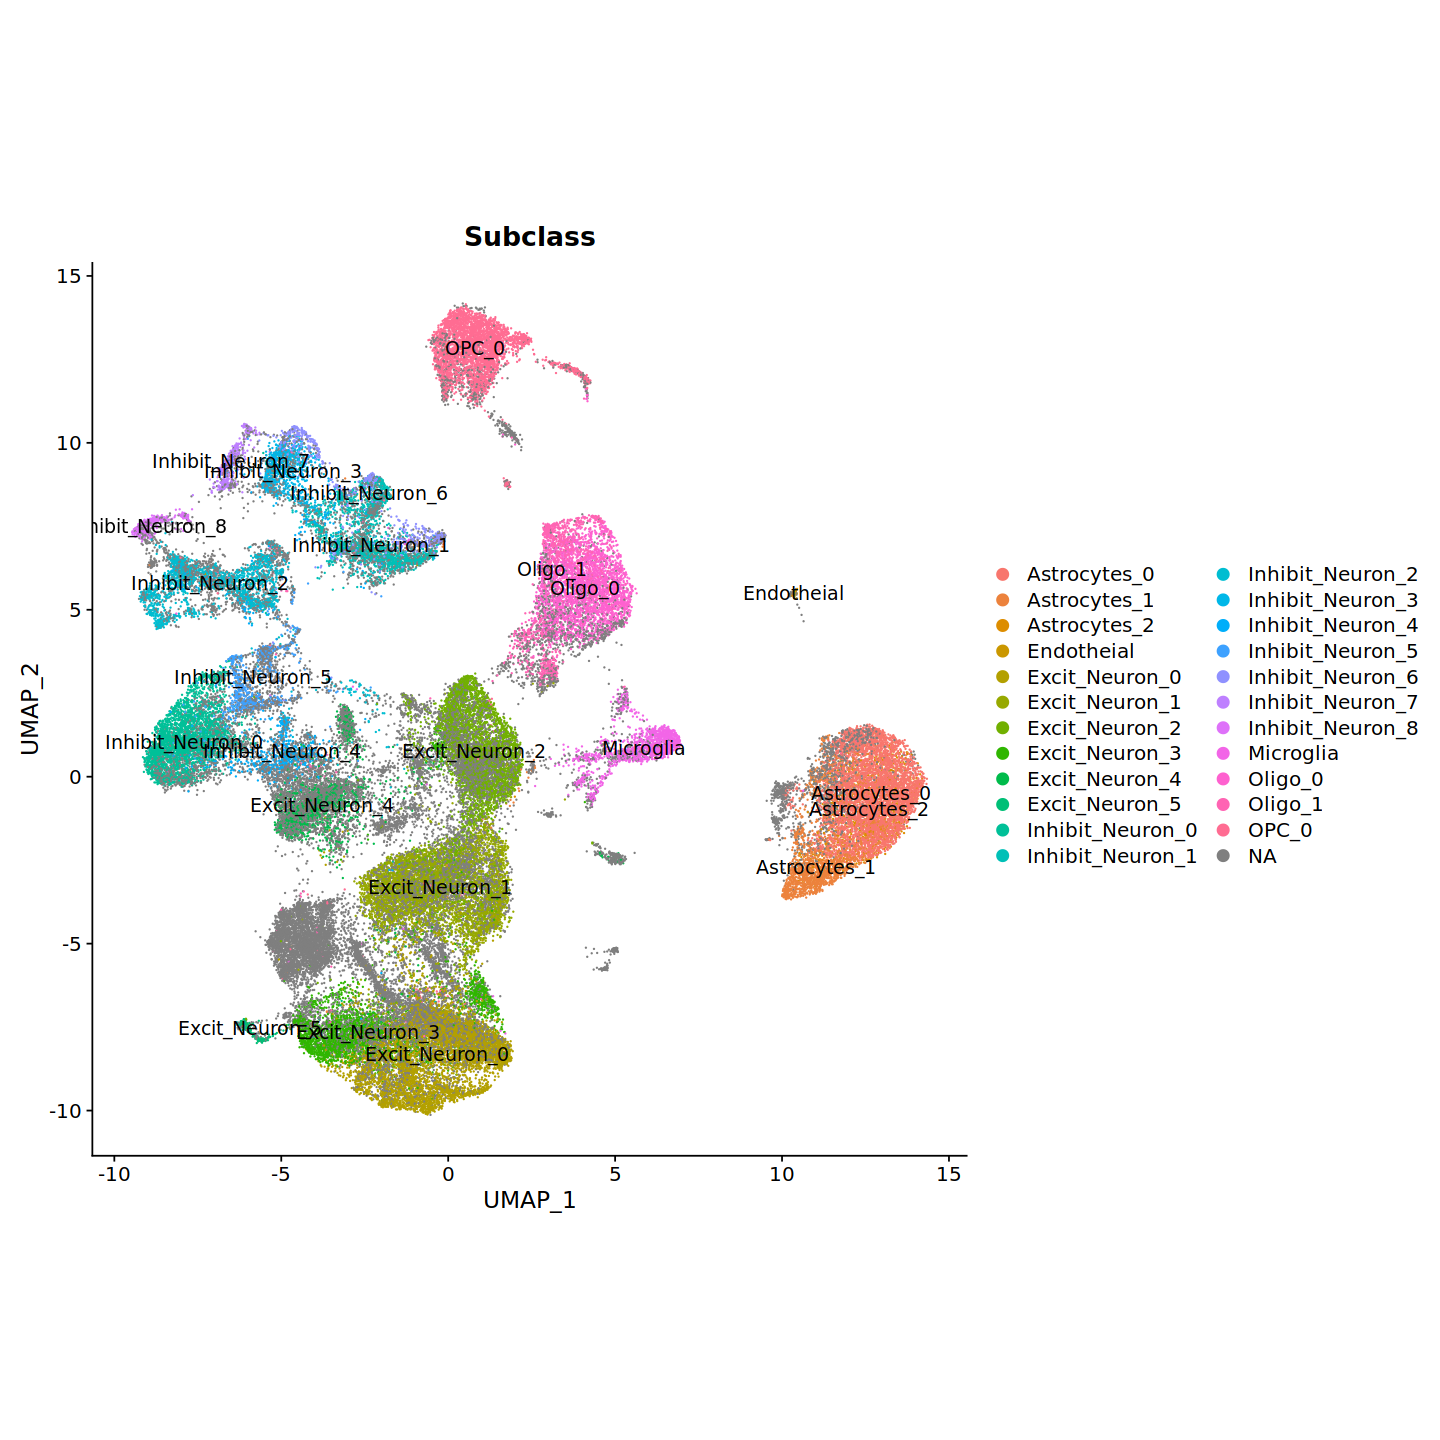

In [13]:
df=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_240115/dif_res_anno/ref_amy.csv')
test=seurat
ref=test@meta.data
ref$cell=rownames(ref)
ref=left_join(ref,df)
test=AddMetaData(test,ref$Subclass,col.name = 'Subclass')

options(repr.plot.width=12, repr.plot.height=12)
DimPlot(test,group.by = 'Subclass',label=T,raster=FALSE)+coord_fixed()


In [15]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,2,3,9,10,20,
                                                        21,26),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(11,12,13,15,16),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(28,18,1),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(5,20),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(31),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(8),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(14),]$class='Microglia'



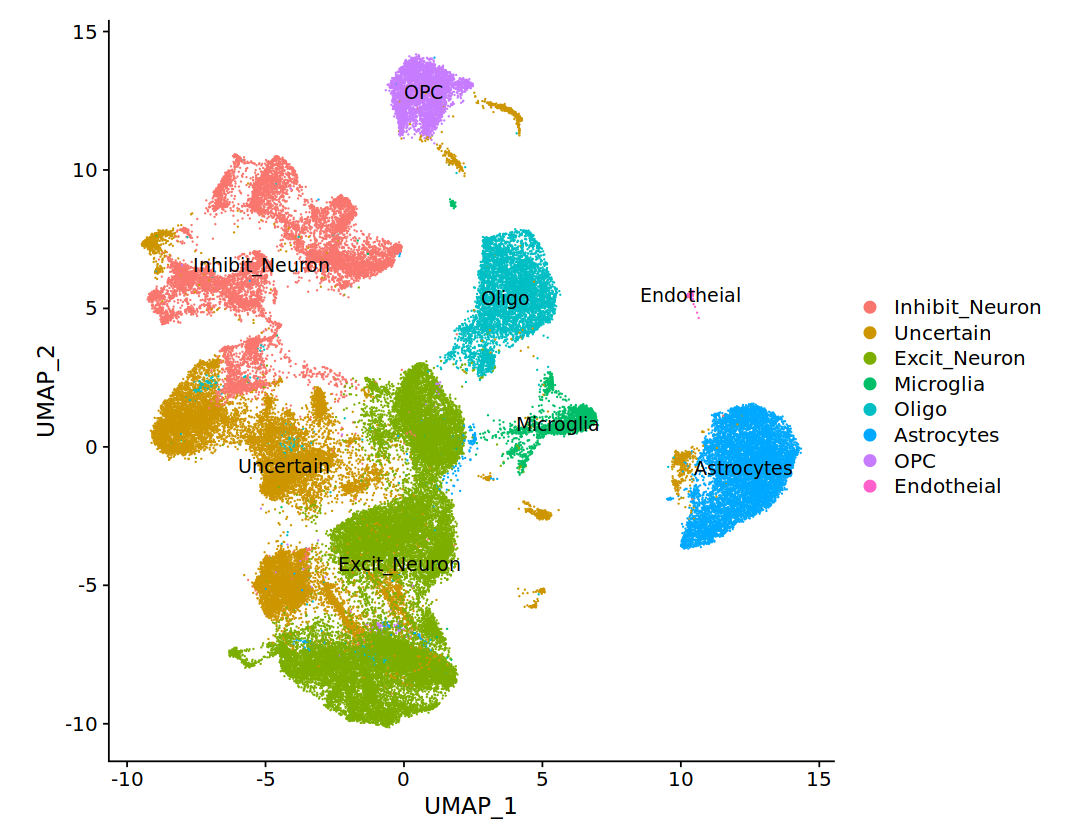

In [16]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [17]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	29170 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000            114           5000           5000           1475 
         Oligo            OPC      Uncertain 
          4476           3105           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000            114           5000           5000           1475 
         Oligo            OPC      Uncertain 
          4476           3105           5000 

In [18]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            76             66              5             22             28 
         Oligo            OPC      Uncertain 
            49             26             10 

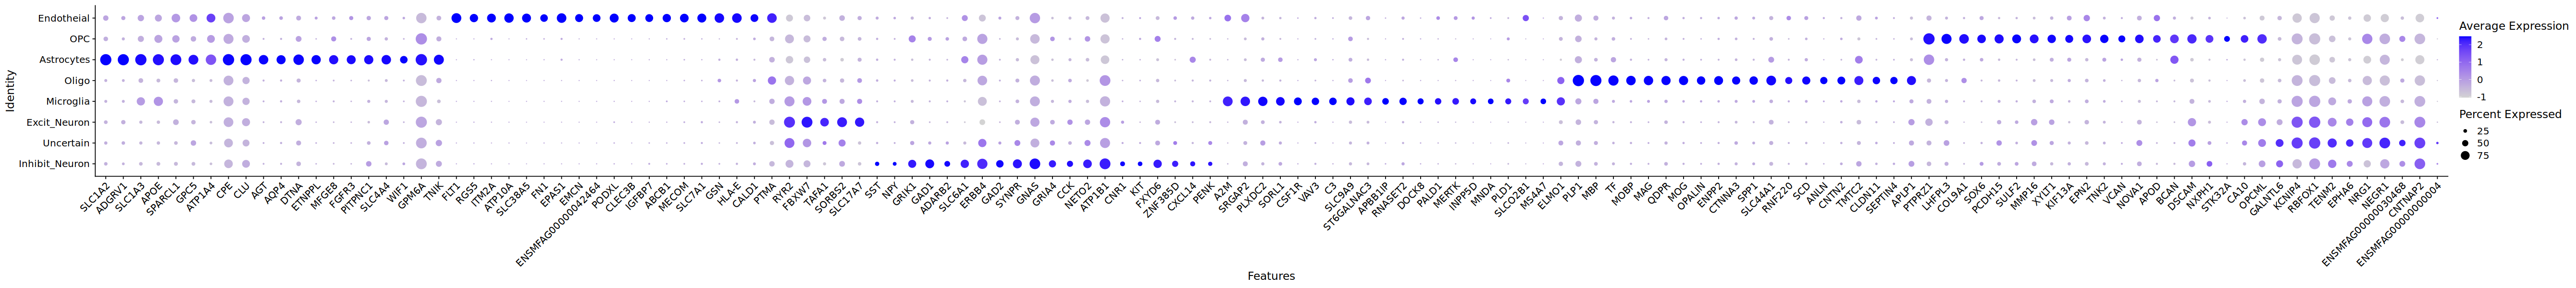

In [19]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()


 num [1:7, 1:8] 4936 13 7 29 3 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


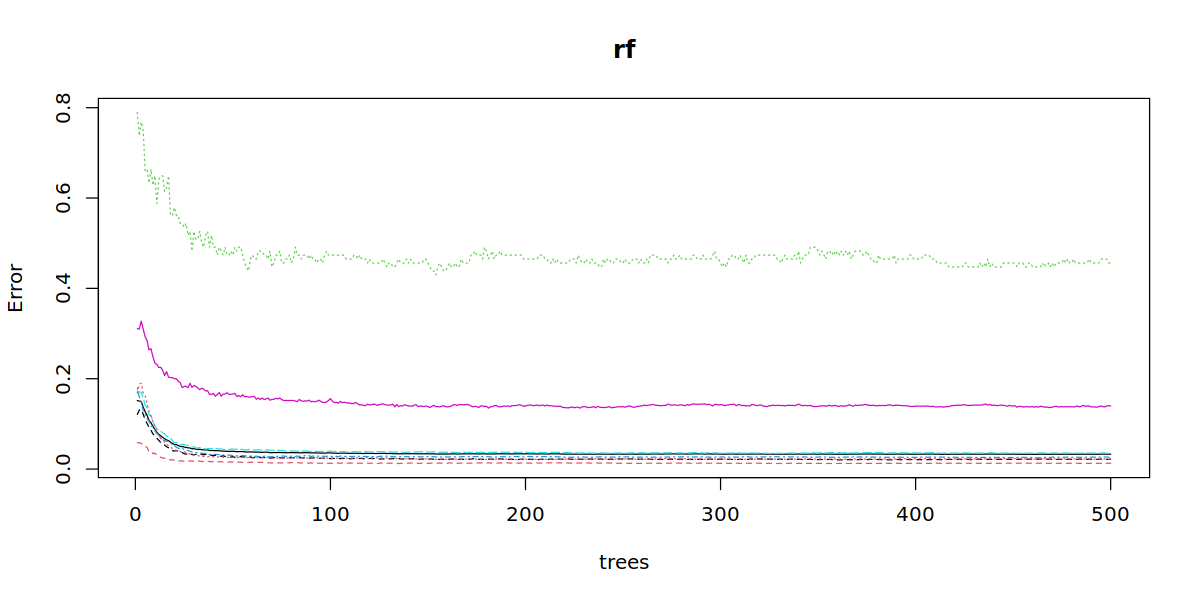

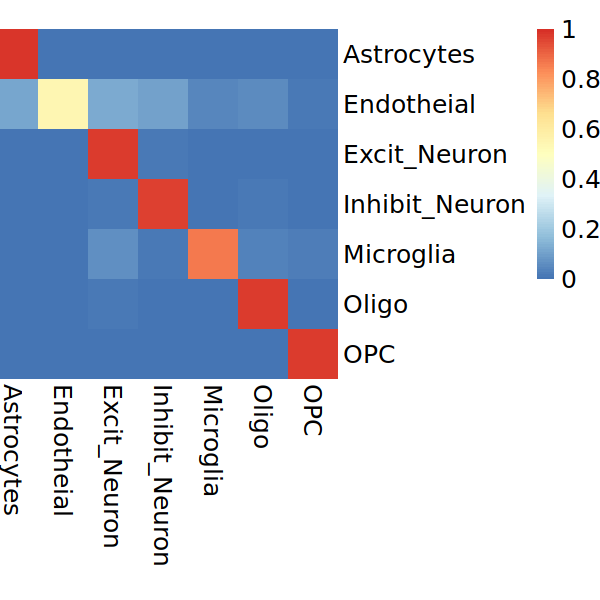

In [20]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:7, 1:7], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)


 'matrix' num [1:75816, 1:7] 0 0.006 0.014 0 0 0.006 0.044 0.008 0.002 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:75816] "MQ179-76T61_CELL1337_N1_1" "MQ179-76T61_CELL416_N1_1" "MQ179-76T61_CELL167_N2_1" "MQ179-76T61_CELL627_N1_1" ...
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId                    maxPredClassScore maxPredClass  
1 MQ179-76T61_CELL1337_N1_1 0.986             Inhibit_Neuron
2 MQ179-76T61_CELL416_N1_1  0.544             Excit_Neuron  
3 MQ179-76T61_CELL167_N2_1  0.686             Excit_Neuron  
4 MQ179-76T61_CELL627_N1_1  0.966             Excit_Neuron  
5 MQ179-76T61_CELL1937_N1_1 0.986             Inhibit_Neuron
6 MQ179-76T61_CELL1320_N1_1 0.758             Microglia

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1940  0.7280  0.9120  0.8339  0.9760  1.0000 

[1] TRUE

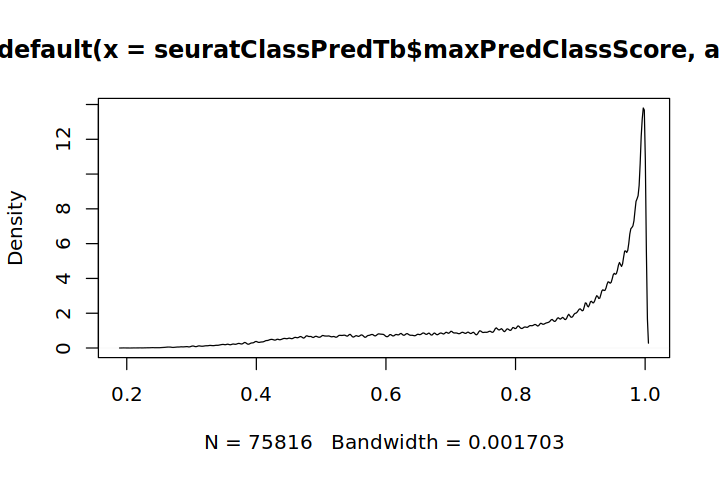

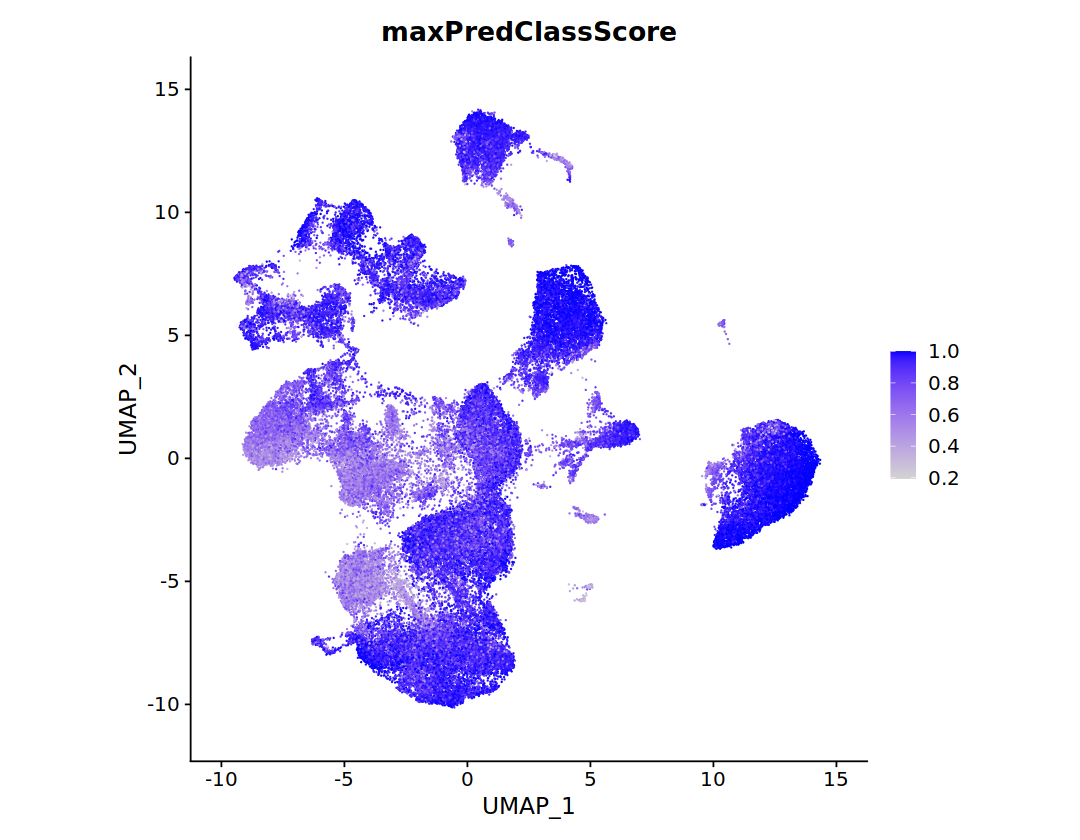

In [21]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [22]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)


Filt cell ratio: 0.681109528331751



In [23]:
classFiltSeurat

An object of class Seurat 
45012 features across 51639 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

In [24]:
Idents(classFiltSeurat) = "maxPredClass"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(classFiltSeurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [25]:
#EXIN按照nfeature800过滤
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat1=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat1

An object of class Seurat 
45012 features across 50527 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

In [27]:
classFiltSeurat

An object of class Seurat 
45012 features across 51639 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

In [26]:
classFiltSeurat1

An object of class Seurat 
45012 features across 50527 samples within 2 assays 
Active assay: SCT (21721 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

In [28]:
saveRDS(classFiltSeurat1,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1019_Putamen_Amygdala_analysis/batch_normalize_renew_240115/amygdala_snrna_all_soupX_fil300_800_anno_SCT_RFfil_240122.rds')


In [29]:
table(classFiltSeurat1$maxPredClass)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          8251             33          22409           9471           1382 
         Oligo            OPC 
          5335           3646 

In [ ]:
ASC_resolution=0.09
EX_resolution=1.3
IN_resolution=1.1
NON_resolution=0.09
MICRO_resolution=0.07
OPC_resolution=0.07


suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

options(future.globals.maxSize= 1000 * 1024^16 )

dataDir=paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/Insular_renew_1016/batch_normalize_renew_240115/dif_res_anno/')

classFiltSeurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/Insular_renew_1016/batch_normalize_renew_240115/insular_snrna_all_soupX_fil300_800_anno_SCT_RFfil_240116.rds')
classFiltSeurat

classFiltSeurat
table(classFiltSeurat@meta.data$maxPredClass)

Excit=subset(classFiltSeurat,maxPredClass=='Excit_Neuron')
Inhibit=subset(classFiltSeurat,maxPredClass=='Inhibit_Neuron')
Astrocytes=subset(classFiltSeurat,maxPredClass=='Astrocytes')
Oligo=subset(classFiltSeurat,maxPredClass=='Oligo')
Microglia=subset(classFiltSeurat,maxPredClass=='Microglia')
OPC=subset(classFiltSeurat,maxPredClass=='OPC')
#MSN=subset(classFiltSeurat,maxPredClass=='MSN')
#VLMC=subset(classFiltSeurat,maxPredClass=='VLMC')
Endotheial=subset(classFiltSeurat,maxPredClass=='Endotheial')



#剔除线粒体基因
assay=Excit@assays$RNA@counts
meta=Excit@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Excit1=CreateSeuratObject(counts  = new_assay)
Excit1=AddMetaData(Excit1,meta)

Excit1 =  NormalizeData(Excit1, normalization.method = "LogNormalize", scale.factor = 10000)
Excit1 = FindVariableFeatures(Excit1, selection.method = "vst", nfeatures = 3000)
Excit1 = ScaleData(Excit1, features = rownames(Excit1))
Excit1 = RunHarmony(
    Excit1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Excit1 = Excit1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = EX_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)


#剔除线粒体基因
assay=Inhibit@assays$RNA@counts
meta=Inhibit@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Inhibit1=CreateSeuratObject(counts  = new_assay)
Inhibit1=AddMetaData(Inhibit1,meta)

Inhibit1 =  NormalizeData(Inhibit1, normalization.method = "LogNormalize", scale.factor = 10000)
Inhibit1 = FindVariableFeatures(Inhibit1, selection.method = "vst", nfeatures = 3000)
Inhibit1 = ScaleData(Inhibit1, features = rownames(Inhibit1))
Inhibit1 = RunHarmony(
    Inhibit1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Inhibit1 = Inhibit1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = IN_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)


#剔除线粒体基因
assay=Astrocytes@assays$RNA@counts
meta=Astrocytes@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Astrocytes1=CreateSeuratObject(counts  = new_assay)
Astrocytes1=AddMetaData(Astrocytes1,meta)

Astrocytes1 =  NormalizeData(Astrocytes1, normalization.method = "LogNormalize", scale.factor = 10000)
Astrocytes1 = FindVariableFeatures(Astrocytes1, selection.method = "vst", nfeatures = 3000)
Astrocytes1 = ScaleData(Astrocytes1, features = rownames(Astrocytes1))
Astrocytes1 = RunHarmony(
    Astrocytes1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Astrocytes1 = Astrocytes1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = ASC_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)


#剔除线粒体基因
assay=Oligo@assays$RNA@counts
meta=Oligo@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Oligo1=CreateSeuratObject(counts  = new_assay)
Oligo1=AddMetaData(Oligo1,meta)

Oligo1 =  NormalizeData(Oligo1, normalization.method = "LogNormalize", scale.factor = 10000)
Oligo1 = FindVariableFeatures(Oligo1, selection.method = "vst", nfeatures = 3000)
Oligo1 = ScaleData(Oligo1, features = rownames(Oligo1))
Oligo1 = RunHarmony(
    Oligo1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Oligo1 = Oligo1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = NON_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)


#剔除线粒体基因
assay=OPC@assays$RNA@counts
meta=OPC@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

OPC1=CreateSeuratObject(counts  = new_assay)
OPC1=AddMetaData(OPC1,meta)

OPC1 =  NormalizeData(OPC1, normalization.method = "LogNormalize", scale.factor = 10000)
OPC1 = FindVariableFeatures(OPC1, selection.method = "vst", nfeatures = 3000)
OPC1 = ScaleData(OPC1, features = rownames(OPC1))
OPC1 = RunHarmony(
    OPC1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
OPC1 = OPC1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = OPC_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)



#剔除线粒体基因
assay=Endotheial@assays$RNA@counts
meta=Endotheial@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Endotheial1=CreateSeuratObject(counts  = new_assay)
Endotheial1=AddMetaData(Endotheial1,meta)

Endotheial1 =  NormalizeData(Endotheial1, normalization.method = "LogNormalize", scale.factor = 10000)
Endotheial1 = FindVariableFeatures(Endotheial1, selection.method = "vst", nfeatures = 3000)
Endotheial1 = ScaleData(Endotheial1, features = rownames(Endotheial1))
Endotheial1 = RunHarmony(
    Endotheial1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Endotheial1 = Endotheial1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = NON_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)

#剔除线粒体基因
assay=Microglia@assays$RNA@counts
meta=Microglia@meta.data
mt_gene=c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
new_assay=assay[setdiff(rownames(assay),mt_gene),]

Microglia1=CreateSeuratObject(counts  = new_assay)
Microglia1=AddMetaData(Microglia1,meta)

Microglia1 =  NormalizeData(Microglia1, normalization.method = "LogNormalize", scale.factor = 10000)
Microglia1 = FindVariableFeatures(Microglia1, selection.method = "vst", nfeatures = 3000)
Microglia1 = ScaleData(Microglia1, features = rownames(Microglia1))
Microglia1 = RunHarmony(
    Microglia1, group.by.vars="sample", plot_convergence=T,
    reduction = "pca", dims.use=1:30,
    theta=2,)
Microglia1 = Microglia1 %>%
    FindNeighbors(reduction="harmony", dims = 1:30) %>%
    FindClusters(verbose = FALSE,resolution = MICRO_resolution) %>%
    RunUMAP(reduction="harmony", dims = 1:30)

Astrocytes1@meta.data$Subclass=paste0(Astrocytes1@meta.data$maxPredClass,'_',Astrocytes1@meta.data$seurat_clusters)
Oligo1@meta.data$Subclass=paste0(Oligo1@meta.data$maxPredClass,'_',Oligo1@meta.data$seurat_clusters)
Microglia1@meta.data$Subclass=paste0(Microglia1@meta.data$maxPredClass,'_',Microglia1@meta.data$seurat_clusters)
OPC1@meta.data$Subclass=paste0(OPC1@meta.data$maxPredClass,'_',OPC1@meta.data$seurat_clusters)
#MSN1@meta.data$Subclass=paste0(MSN1@meta.data$maxPredClass,'_',MSN1@meta.data$seurat_clusters)
Endotheial1@meta.data$Subclass=paste0(Endotheial1@meta.data$maxPredClass,'_0')
Excit1@meta.data$Subclass=paste0(Excit1@meta.data$maxPredClass,'_',Excit1@meta.data$seurat_clusters)
Inhibit1@meta.data$Subclass=paste0(Inhibit1@meta.data$maxPredClass,'_',Inhibit1@meta.data$seurat_clusters)




sub1=Astrocytes1@meta.data[,'Subclass',drop=F]
sub2=Oligo1@meta.data[,'Subclass',drop=F]
sub3=Microglia1@meta.data[,'Subclass',drop=F]
sub4=OPC1@meta.data[,'Subclass',drop=F]
#sub5=MSN1@meta.data[,'Subclass',drop=F]
sub6=Excit1@meta.data[,'Subclass',drop=F]
sub7=Inhibit1@meta.data[,'Subclass',drop=F]
#sub8=VLMC@meta.data[,'Subclass',drop=F]
sub9=Endotheial1@meta.data[,'Subclass',drop=F]

sub_2=rbind(sub1,sub2,sub3,sub4,sub6,sub7,sub9)

df_dir=dataDir

classFiltSeurat=AddMetaData(classFiltSeurat,sub_2,col.name = 'Subclass')

classFiltSeurat
table(classFiltSeurat$Subclass)

df_dir=dataDir
save_file_name=paste0(df_dir,EX_resolution,'_res',IN_resolution,'_res',NON_resolution,'_anno.csv')
write.csv(sub_2,save_file_name)


classFiltSeurat=AddMetaData(classFiltSeurat,sub_2,col.name = 'Subclass')

classFiltSeurat
table(classFiltSeurat$Subclass)

# 每个class抽样80%，最多3000个细胞
seurat=classFiltSeurat
sampleRatio = 0.8
maxCell = 3000
sampleDf = seurat@meta.data[, c("Subclass"), drop=F]
sampleList = split(sampleDf, sampleDf$Subclass)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$Subclass)

saveDir=paste0(dataDir,'train_seurat/')
#saveRDS(trainSeurat,paste0(saveDir,'res',EX_resolution,'_res',IN_resolution,'_traindata.rds'))
#trainSeurat=readRDS(paste0(saveDir,'res',EX_resolution,'_res',IN_resolution,'_traindata.rds'))
Idents(trainSeurat) = "Subclass"
plan("multicore", workers = 5)
classMarker = FindAllMarkers(trainSeurat)
write_tsv(classMarker, paste0(saveDir, "/train_res",EX_resolution,'_res',IN_resolution,'_res',NON_resolution,"_downsample3000_subclass_marker.tsv"))


classMarker=read.table(paste0(saveDir, "/train_res",EX_resolution,'_res',IN_resolution,'_res',NON_resolution,"_downsample3000_subclass_marker.tsv"))
colnames(classMarker)=classMarker[1,]
classMarker=classMarker[-1,]

#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)


classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=40, repr.plot.height=10)
#Idents(seurat) = "Subclass"
#DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$Subclass = trainSeurat$Subclass
trainDf$Subclass = factor(trainDf$Subclass)



# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_Subclass~., data=trainDf, ntree=500)

saveRDS(rf, paste0(saveDir, "/Subclass.randomForest.20230627res",EX_resolution,'_res',IN_resolution,".rds"))
